# Neural Network Training

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import torch.optim as optim

from extravaganza.dynamical_systems import LinearRegression, MNIST

from extravaganza.observables import Observable, TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.lifters import Identity, NN
from extravaganza.system_models import LiftedController, OfflineSysid, HardFTH
from extravaganza.explorer import Explorer
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpy_pywjs9
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpy_pywjs9/_remote_module_non_scriptable.py


## System
Here, we tune the parameters of a gradient descent algorithm training a neural network. We can train either a linear regression or an MLP or CNN MNIST model. Any optimizer can be used, such as `SGD` or `Adam`, and any parameter can be tuned, such as `lr` or `momentum`. 

Which optimizer to use is specified in the `make_optimizer` argument, and how to update and tune things is specified in the `apply_control` argument.

At the moment, we apply a 2-dimensional control $u = (u_0, u_1)$ that dictates 2 parameters of the learning rate schedule, given as
$$\eta_t := \frac{u_0}{1 + u_1 \cdot \sqrt{t}},$$
where $u_0$ is the initial learning rate and $u_1$ is a decay rate.

## Hyperparameters

In [41]:
def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 40000  # total timesteps
    T0 = 4000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: t % 4000 == 0  # when to reset the system (which means fresh LR/MNIST model params)
    use_multiprocessing = False  # unsure if this works in jupyter notebooks
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    base_lr = 0.15
    initial_control = np.array([0.])
    du = initial_control.shape[0]
    
    make_optimizer = lambda model: optim.SGD(model.parameters(), lr=base_lr)
#     make_optimizer = lambda model: optim.Adam(model.parameters(), lr=initial_lr)

    def apply_control(control, system): system.opt.param_groups[0]['lr'] = np.clip(control[0].item() + base_lr, 1e-3, 0.7)

#     make_system = lambda : LinearRegression(make_optimizer, apply_control,
#                                             dataset = 'generated', 
#                                             repeat = 3,
#                                             eval_every = 1, seed=SYSTEM_SEED)   

    make_system = lambda : MNIST(make_optimizer, apply_control,
                                 model_type = 'MLP', batch_size = 256,
                                 repeat = 1,
                                 eval_every=None, seed=SYSTEM_SEED)

    hh = 1
    observable = TimeDelayedObservation(hh = hh, control_dim=du, state_dim=3, time_embedding_dim=4,
                                        use_states=False, use_cost_diffs=False,
                                        use_costs=True, use_controls=False, use_time=False)
#     observable = FullObservation(state_dim=3)
    do = observable.obs_dim  # dimension of observations to lift from

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 2  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.999), use_bias_correction=True)
#     m0_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.999), use_bias_correction=True)
    k_update_rescaler = lambda : ADAM(alpha=0.001, betas=(0.9, 0.999), use_bias_correction=True)
#     m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.)
    m0_update_rescaler = lambda : FIXED_RESCALE(alpha=0.02)
#     k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.0)

    evan_bpc_args = {
        'h': h,  
        'method': 'FKM',
        'initial_scales': (0.005, 0.02, 0.005),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
#         'bounds': (-base_lr, base_lr),
        'initial_u': initial_control,
        'decay_scales': False,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'smoothing': 1,
        'seed': CONTROLLER_SEED
    }
    
    # adaptive
    def make_adaptive_controller(sys, name):
        explorer = Explorer(mean=np.zeros(du), std=0.05)
        def mc(dataset):
            lifter = Identity(do, du, normalize=False)
            lifter.train(dataset)
    #         lifter = NN(do, du, dl, dl, 'learned', 4)
    #         lifter.train(dataset, 8000, 256)
            Ahat, Bhat = lifter.AB['regression']
    #         print(summarize_lds(Ahat, Bhat))

            if name == 'LQR': c = LQR(A=Ahat, B=Bhat)
            elif name == 'HINF': c = HINF(A=Ahat, B=Bhat, T=T)
            elif name == 'GPC': c = GPC(A=Ahat, B=Bhat, H=5, lr_scale=0.01, decay=True)
            elif name == 'BPC': c = BPC(A=Ahat, B=Bhat, H=h, lr_scale=0.01, decay=True, delta=0.001)
            elif name == 'RBPC': c = RBPC(A=Ahat, B=Bhat, M=h, lr=0.02, delta=0.001, noise_sd=0.025)
            elif name == 'Evan BPC': c = EvanBPC(A=Ahat, B=Bhat, **evan_bpc_args)
            else: raise NotImplementedError()
            return LiftedController(c, lifter)
        return HardFTH(du, do, explorer, mc, eta=0.8, T0=T0, spawn_every=256, dataset_window=1000, min_lifetime=128)
    
    make_controllers = {
        'adaptive Evan BPC': lambda sys: make_adaptive_controller(sys, 'Evan BPC'),
#         '{}'.format(round(base_lr, 2)): lambda sys: ConstantController(np.zeros(du), do),
    }
    experiment_args = {    
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': None,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [42]:
# run
name = 'mnist_0.15'
filename = '../logs/{}.pkl'.format(name)
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing adaptive Evan BPC
INFO: (MNIST): loaded MNIST dataset! we will NOT be validating
INFO: (EXPLORER) generating exploration control sequences using ['random', 'repeat', 'impulse'] w.p. [1. 0. 0.]
100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [02:10<00:00, 306.25it/s, control=-.0759, cost=0.0185]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 133.74999233311974 seconds


In [ ]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename) 

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

<Figure size 640x480 with 0 Axes>

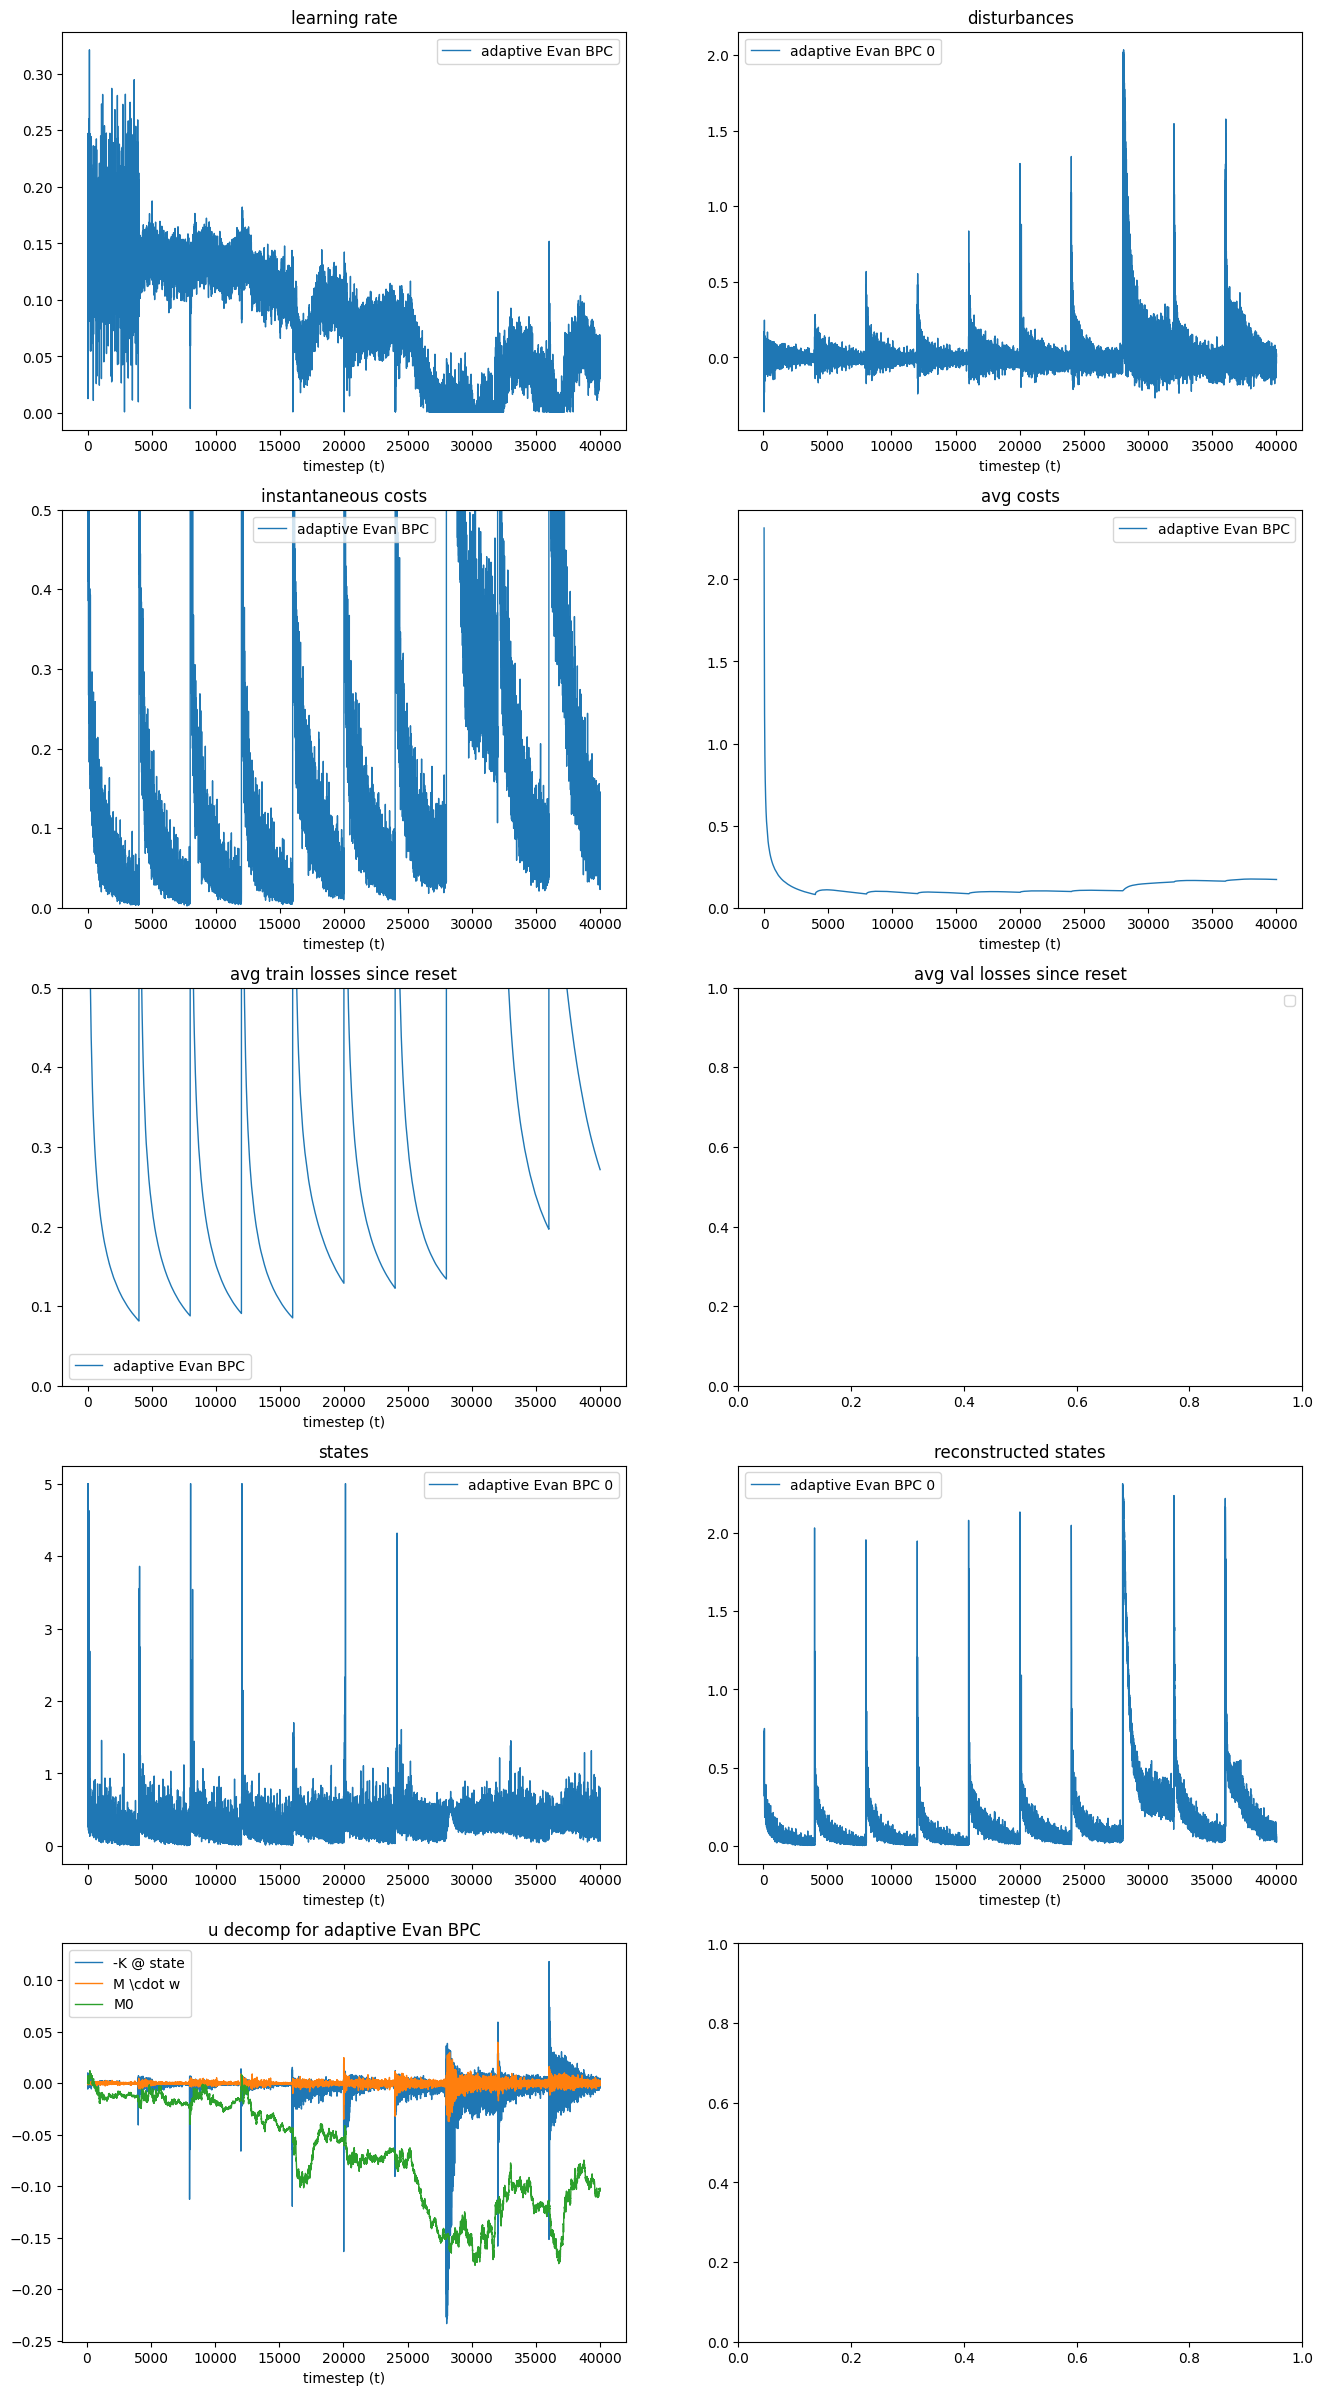

In [40]:
def plot(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'lrs', label=method)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        stats.plot(ax[2, 0], 'avg train losses since reset', label=method)
        stats.plot(ax[2, 1], 'avg val losses since reset', label=method)        
        
        for j in range(1):
            stats.plot(ax[3, 0], 'true states', label=method + ' ' + str(j), plot_idx=j)  # state
            stats.plot(ax[3, 1], 'states', label=method + ' ' + str(j), plot_idx=j)  # "state"
            stats.plot(ax[0, 1], 'disturbances', label=method + ' ' + str(j), plot_idx=j)
            
        i_ax = ax[n + i // 2, i % 2]
        idx = 0
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=idx)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=idx)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=idx)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('learning rate'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend(); ylim(_ax, 0, 0.5)
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 10000)
    _ax = ax[2, 0]; _ax.set_title('avg train losses since reset'); _ax.legend(); ylim(_ax, 0, 0.5)
    _ax = ax[2, 1]; _ax.set_title('avg val losses since reset'); _ax.legend()
    _ax = ax[3, 0]; _ax.set_title('states'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('reconstructed states'); _ax.legend()  
    pass
plot(experiment)

### Dynamic Plot

# dynamic plot
anim = render(experiment, 'lrs', 'train losses', sliderkey='lrs', save_path=None, duration=5)
vid = anim.to_html5_video()
HTML(vid)